In [1]:
!nvidia-smi

Wed Jan 25 10:00:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 30%   40C    P8    17W / 250W |   4739MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 40%   

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import datetime
import matplotlib.pyplot as plt
import tqdm

from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.adam import Adam
from torchvision.transforms import Compose, ToTensor, Resize

## Data 살펴보기

In [4]:
import torchvision.transforms as T

from torchvision import datasets
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, Normalize

transforms = Compose([
#    RandomCrop((32, 32), padding=4),
#    RandomHorizontalFlip(p=0.5),
    Resize([128, 128]),
    ToTensor(),
   # ➊ 데이터 정규화
#    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
])

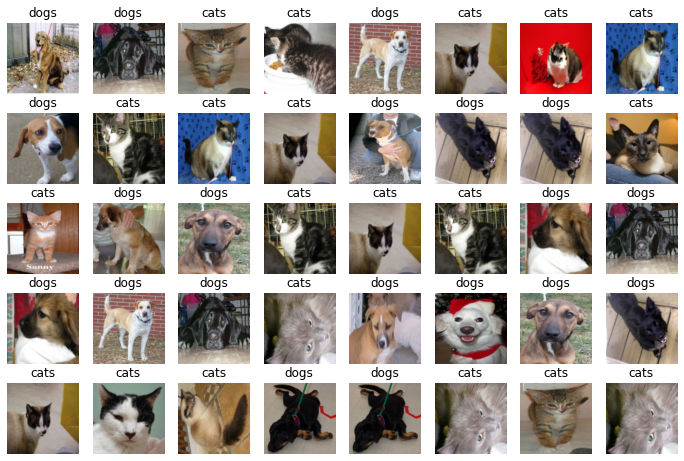

In [5]:
train_data = datasets.ImageFolder('../data/dogncat/training_set/training_set',transform=transforms)
test_data = datasets.ImageFolder('../data/dogncat/test_set/test_set',transform=transforms)

# ❷ 데이터로더 정의
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

images, labels = next(iter(train_loader))

# ImageFolder의 속성 값인 class_to_idx를 할당
labels_map = {v:k for k, v in train_data.class_to_idx.items()}

figure = plt.figure(figsize=(12, 8))
cols, rows = 8, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()

In [6]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim):
        super(BasicBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, hidden_dim,
                               kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, out_channels,
                               kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        return x

In [7]:
class CNN(nn.Module):
    def __init__(self, num_classes): # num_classes는 클래스의 개수를 의미합니다
       super(CNN, self).__init__()

       # ❶ 합성곱 기본 블록의 정의
       self.block1 = BasicBlock(in_channels=3, out_channels=32, hidden_dim=16)
       self.block2 = BasicBlock(in_channels=32, out_channels=128, hidden_dim=64)
       self.block3 = BasicBlock(in_channels=128, out_channels=128, 
                                hidden_dim=128)

       # ❷ 분류기 정의
       self.fc1 = nn.Linear(in_features=128*16*16 , out_features=2048)
       self.fc2 = nn.Linear(in_features=2048, out_features=256)
       self.fc3 = nn.Linear(in_features=256, out_features=num_classes)


       # ❸ 분류기의 활성화 함수
       self.relu = nn.ReLU()
       self.sigmoid = nn.Sigmoid()



    def forward(self, x):
       x = self.block1(x)
       x = self.block2(x)
       x = self.block3(x)  # 출력 모양: (-1, 256, 4, 4) 
       x = torch.flatten(x, start_dim=1) # ➍ 2차원 특징맵을 1차원으로

       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)
       x = self.relu(x)
       x = self.fc3(x)
       x = self.sigmoid(x)


       return x

In [8]:
# ❸ 학습을 진행할 프로세서 설정
device = "cuda" if torch.cuda.is_available() else "cpu"


# ➍ CNN 모델 정의
# model = CNN(num_classes=2)
model = CNN(num_classes=1)

# ➎ 모델을 device로 보냄
model.to(device)

CNN(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=32768, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256

In [9]:
images, labels = next(iter(train_loader))
images.shape, labels.shape
# 32장 배치로 채널 3, 세로 224, 가로 224 의미 

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [10]:
# ❶ 학습률 정의
lr = 5e-4

# ❷ 최적화 기법 정의
optim = Adam(model.parameters(), lr=lr)

# 학습 루프 정의
for epoch in range(20):
    iterator = tqdm.tqdm(train_loader)
    for data, label in iterator:  # ➌ 데이터 호출
       optim.zero_grad()  # ➍ 기울기 초기화

       preds = model(data.to(device)).to(torch.float32)  # ➎ 모델의 예측
       
              # ➏ 오차역전파와 최적화
#        loss = nn.BCELoss()(preds.squeeze(1).to(torch.float32), label.to(device).to(torch.float32)) 
       loss = nn.BCELoss()(preds.squeeze(1), label.to(device).to(torch.float32)) 
       loss.backward() 
       optim.step() 
    
#     if epoch==0 or epoch%10==9:  # 10번마다 손실 출력 
    
    print(f"epoch{epoch+1} loss:{loss.item()}")
    


# 모델 저장
torch.save(model.state_dict(), "../CatnDog.pth")

100%|██████████| 251/251 [00:22<00:00, 11.28it/s]


epoch1 loss:0.700598418712616


100%|██████████| 251/251 [00:21<00:00, 11.57it/s]


epoch2 loss:0.7072741389274597


100%|██████████| 251/251 [00:21<00:00, 11.70it/s]


epoch3 loss:0.6278113722801208


100%|██████████| 251/251 [00:22<00:00, 11.39it/s]


epoch4 loss:0.3652746081352234


100%|██████████| 251/251 [00:21<00:00, 11.43it/s]


epoch5 loss:0.4893537163734436


100%|██████████| 251/251 [00:22<00:00, 11.31it/s]


epoch6 loss:0.9353046417236328


100%|██████████| 251/251 [00:22<00:00, 11.29it/s]


epoch7 loss:0.8810009956359863


100%|██████████| 251/251 [00:22<00:00, 11.19it/s]


epoch8 loss:0.012427196837961674


100%|██████████| 251/251 [00:22<00:00, 11.40it/s]


epoch9 loss:0.006570832338184118


100%|██████████| 251/251 [00:22<00:00, 11.18it/s]


epoch10 loss:0.02640729583799839


100%|██████████| 251/251 [00:21<00:00, 11.71it/s]


epoch11 loss:0.021597102284431458


100%|██████████| 251/251 [00:21<00:00, 11.50it/s]


epoch12 loss:0.0019526680698618293


100%|██████████| 251/251 [00:21<00:00, 11.61it/s]


epoch13 loss:0.0003221197985112667


100%|██████████| 251/251 [00:21<00:00, 11.51it/s]


epoch14 loss:0.0029455148614943027


100%|██████████| 251/251 [00:22<00:00, 11.37it/s]


epoch15 loss:0.0001820979086915031


100%|██████████| 251/251 [00:21<00:00, 11.44it/s]


epoch16 loss:0.061819758266210556


100%|██████████| 251/251 [00:21<00:00, 11.60it/s]


epoch17 loss:0.00026155676459893584


100%|██████████| 251/251 [00:21<00:00, 11.71it/s]


epoch18 loss:0.009228486567735672


100%|██████████| 251/251 [00:21<00:00, 11.43it/s]


epoch19 loss:3.4382715966785327e-05


100%|██████████| 251/251 [00:21<00:00, 11.46it/s]


epoch20 loss:5.912184133194387e-05


In [12]:
model.load_state_dict(torch.load("../CatnDog.pth", map_location=device))

num_corr = 0

with torch.no_grad():
   for data, label in test_loader:

       output = model(data.to(device))
       preds = output.data.max(1)[1]
       corr = preds.eq(label.to(device).data).sum().item()
       num_corr += corr

   print(f"Accuracy:{num_corr/len(test_data)}")

Accuracy:0.49975284231339595
